## LLM

In [1]:
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from src.tokenizer import TokenizerBPE, word_split, normalize_to_ascii

import os
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from src.transformer import *
from src.data_handling import read_first_n, sample_batch


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available:  1


In [2]:
#tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [2]:
tokenizer = pkl.load(open("tokenizers/tokenizer_CNN16000_lowercase.pkl", 'rb'))
tokenizer.create_hash()

random.seed(42)
corpus_indicies = pkl.load(open('corpus/CNN_tokenized16000_lowercase.pkl', 'rb'))
random.shuffle(corpus_indicies)

## Define Model

In [3]:
class WarmUpThenDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,
                 initial_learning_rate: float,
                 warmup_steps: int,
                 decay_schedule_fn: tf.keras.optimizers.schedules.LearningRateSchedule):
        """
        initial_learning_rate: peak LR reached at end of warmup
        warmup_steps:      # of steps to ramp from 0 → initial_learning_rate
        decay_schedule_fn: a tf.keras schedule to apply *after* warmup
        """
        super().__init__()
        self.initial_lr = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_schedule_fn = decay_schedule_fn

    def __call__(self, step):
        # Cast to float32 for safety in graph mode
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)

        # compute linear warmup: lr = initial_lr * (step / warmup_steps)
        warmup_lr = self.initial_lr * (step / warmup_steps)

        # after warmup_steps, switch to decay schedule (shift step count)
        decay_step = step - warmup_steps
        decay_lr = self.decay_schedule_fn(decay_step)

        # if step < warmup_steps, pick warmup_lr, else decay_lr
        return tf.cond(step < warmup_steps,
                       lambda: warmup_lr,
                       lambda: decay_lr)
    


In [4]:
initial_lr = 1e-3
decay_steps = 50000
decay_rate = 0.5
decay_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False)

warmup_steps = 10000
lr_schedule = WarmUpThenDecay(
    initial_learning_rate=initial_lr,
    warmup_steps=warmup_steps,
    decay_schedule_fn=decay_schedule)

np.random.seed(42)
tf.random.set_seed(42)

max_seq_len = 200
embed_dim = 1024
tf_blocks = 8
heads = 8
ff_dim = 4*embed_dim

unembed_dims = []

model = Transformer(vocab_size=tokenizer.vocab_size,
                    max_seq_len=max_seq_len,
                    embed_dim=embed_dim,
                    tf_blocks=tf_blocks,
                    heads=heads,
                    ff_dim = ff_dim,
                    unembed_dims=unembed_dims,
                    lr=lr_schedule,
                    wd = 0.01,
                    )

losses_train = []
losses_test = []


In [5]:
name = "model_16k_tokens_lowercase_8blocks_wt"


ckpt = tf.train.Checkpoint(
    optimizer=model.optimizer,
    model=model
)
ckpt_manager = tf.train.CheckpointManager(
    ckpt, 
    directory="checkpoints/" + name,      # folder where ckpts are saved
    max_to_keep=5                         # only keep 5 latest checkpoints
)

In [6]:
ckpt.restore(ckpt_manager.latest_checkpoint)
losses_train, losses_test = pkl.load(open("checkpoints/losses_" + name + ".pkl", 'rb'))

In [7]:
total_params = 0
for var in model.parameter_list:
    shape = var.get_shape()
    num_params = 1
    for dim in shape:
        num_params *= dim
    total_params += num_params
print(f"Total number of parameters: {total_params}")

Total number of parameters: 117413574


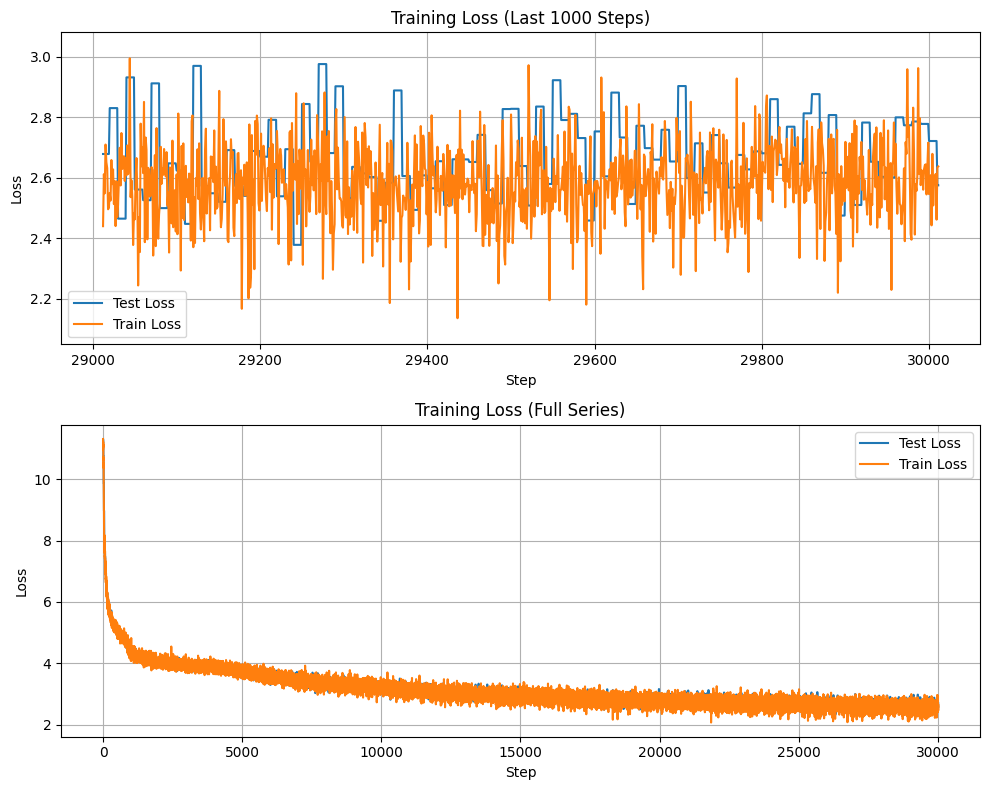

KeyboardInterrupt: 

In [348]:
batch_size = 8
for i in tqdm(range(100000)):
    indices, y_true = sample_batch(corpus_indicies[:90000], 
                                   batch_size, 
                                   tokenizer, 
                                   max_seq_len)
    
    
    loss_train = model.train_step(indices, y_true).numpy()
    losses_train.append(loss_train)


    if i % 10 == 0:
        indices, y_true = sample_batch(corpus_indicies[90000:], 
                                    batch_size, 
                                    tokenizer, 
                                    max_seq_len)
        
        loss_test = model.evaluate(indices, y_true).numpy()
        
    losses_test.append(loss_test)

    if (i+1) % 1000 == 0:
        ckpt_manager.save()
        pkl.dump([losses_train, losses_test], open("checkpoints/losses_" + name + ".pkl", 'wb'))

    clear_output(wait=True)

    # prepare x-axis for the last 400 steps
    start = max(0, len(losses_train) - 1000)
    x_zoom = np.arange(start, len(losses_train))

    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

    # Top subplot: zoom on last 400 steps
    ax1 = axes[0]
    ax1.plot(x_zoom, losses_test[-1000:], label="Test Loss")
    ax1.plot(x_zoom, losses_train[-1000:], label="Train Loss")

    _min = min(losses_train[-1000:] + losses_test[-1000:])
    _max = max(losses_train[-1000:] + losses_test[-1000:])
    delta = _max - _min
    ax1.set_ylim(_min - 0.1 * delta, _max + 0.1 * delta)

    ax1.set_title("Training Loss (Last 1000 Steps)")
    ax1.set_xlabel("Step")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)

    # Bottom subplot: full series
    ax2 = axes[1]
    ax2.plot(losses_test, label="Test Loss")
    ax2.plot(losses_train, label="Train Loss")

    ax2.set_title("Training Loss (Full Series)")
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [8]:
def tokenize(indices, merge_list):
    indices = np.array(indices)
    for pair, new_idx in merge_list:
        slice = np.where(np.logical_and(indices[:-1] == pair[0],  indices[1:] == pair[1]))
        if len(slice[0]) > 0:
            indices[:-1][slice] = new_idx
            indices = np.delete(indices, (slice[0]+1))

    return tf.expand_dims(tf.convert_to_tensor(indices, dtype=tf.int32), axis=0)

In [37]:
text = "The resolution to the israel-palestine conflict"
text = text.lower()

indices = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
indices = tokenize(indices, tokenizer.merge_list)
print(indices)

tf.Tensor(
[[   72     1  4265     1    83     1    72     1  1617    14 13140     1
   2687]], shape=(1, 13), dtype=int32)


In [38]:
T = 0.5
tf.random.set_seed(42)
for i in range(200):
    logits = model.call(indices)[0,-1:]
    idx = tf.cast(tf.random.categorical(logits/T, num_samples=1), tf.int32)
    indices = tf.concat([indices, idx], axis=1)
    text_pred = tokenizer.detokenize(indices)
    text_pred = text_pred.numpy()[0].decode('utf-8').replace("\n", " ")
    print(text_pred, end='\r', flush=True)
    #time.sleep(0.05)


In [39]:
from sklearn.cluster import KMeans

def cosine_similarity(embed_a, embed_b):
    """
    Compute the cosine similarity between two vectors.
    """
    embed_b_T = tf.transpose(embed_b)
    dot_product = embed_a@embed_b_T
    
    norm_a = tf.linalg.norm(embed_a, axis=1, keepdims=True)
    norm_b = tf.linalg.norm(embed_b_T, axis=0, keepdims=True)

    return dot_product / (norm_a * norm_b)


def cluster(X, n_clusters):
    X = X/np.linalg.norm(X, axis=1, keepdims=True)

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    inertia = kmeans.inertia_
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_

    return inertia, labels, clusters


class EmbeddingClustering:
    def __init__(self, tokenizer, n_clusters=10):
        
        self.tokenizer = tokenizer
        self.n_clusters = n_clusters

    def fit(self, word_embed):
        inertia, labels, clusters = cluster(word_embed, self.n_clusters)
        self.word_embed = word_embed
        self.inertia = inertia
        self.labels = labels
        self.clusters = tf.convert_to_tensor(clusters, dtype=tf.float32)

        cos_sim = cosine_similarity(self.clusters, word_embed)
        self.idx_list =  tf.argsort(cos_sim, axis=-1, direction='DESCENDING', stable=False, name=None)

    def print_clusters(self, n_words=10):
        for idx in self.idx_list:
            for i in idx[:n_words]:
                word = self.tokenizer.detokenize(tf.expand_dims(tf.cast(i, tf.int32), axis=0))
                word = word.numpy().decode('utf-8')
                print(word)
            print("\n")

In [344]:
word_embed = model.word_embed

embedding_clustering = EmbeddingClustering(tokenizer, n_clusters=100)
embedding_clustering.fit(word_embed)
embedding_clustering.print_clusters(n_words=10)

colors
dresses
lips
makeup
dress
jeans
pieces
beauty
buttons
hair


damasc
0s
hurrican
mingham
nairo
sterdam
propof
barcelon
traged
catastro


hurrican
mingham
raik
prede
environ
recor
agric
theless
uguay
eleph


acare
assaul
inev
attem
adjac
ailand
wawrink
emerg
controver
strengthe


citiz
}
invol
dipl
itored
moil
possib
acare
eleph
environ


insurgent
haqqani
insurgency
airstrike
infantry
jihadist
environ
{
streng
abulary


a
the
some
an
more
many
this
one
their
his


hezbol
recor
mingham
environ
raik
hurrican
uguay
eleph
adjac
catastro


citiz
acp
firs
onathan
idency
employe
hift
streng
abulary
mogad


0s
injiang
wawrink
raik
alep
weren
endum
onathan
inev
portugu


hezbol
injiang
sterdam
mogad
wawrink
indust
propof
guate
citiz
assaul


wondering
wondered
think
believe
know
realize
understand
convinced
skeptical
worry


citiz
mogad
signific
injiang
abulary
luscon
immen
portra
hurrican
adjac


chry
discre
condem
nostal
teles
incar
refr
leng
subur
prelim


pleaded
appealed
refused
inst

# Overlap

In [41]:
word_embed = model.word_embed

text = "adam"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
embed = tf.expand_dims(word_embed[idx[0][0]], axis=0)

cosine_sim = embed@tf.transpose(word_embed)
idx = tf.argsort(cosine_sim, axis=-1, 
                 direction='DESCENDING',
                 #direction='ASCENDING', 
                 stable=False, name=None)[0]

for i in idx[:100]:
    i = tf.expand_dims(i, axis=0)
    print(tokenizer.detokenize(i).numpy().decode('utf-8'))

tf.Tensor([[3801]], shape=(1, 1), dtype=int32)
adam
kathleen
steven
denise
jaze
theastern
invol
milwau
jason
performan
susan
jamie
heather
cigare
surveill
proble
independ
rory
mitch
darren
lz
highlight
agric
controver
doug
melissa
jeff
demp
oppon
aaron
joel
greg
eign
weren
trayvon
justin
buil
tyler
mingham
alan
dono
randy
claugh
strengthe
larry
wend
tournam
kevin
perpe
emerg
determ
propof
manh
surger
foun
guaran
drawal
damasc
alvar
emma
wedn
kenneth
kend
lionel
volunt
frances
luscon
shakespe
possib
secutive
cindy
kathy
uguay
consid
yugo
vangira
riculum
0s
setts
obst
postpon
petrole
nintend
raymond
leah
jeffrey
nancy
hurrican
inev
acare
palestin
itored
tom
cinc
fundam
usalem
jeb
jeremy
christine
valerie


In [62]:
text = "obama"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
embed1 = tf.expand_dims(word_embed[idx[0][0]], axis=0)

text = "obama"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
embed2 = tf.expand_dims(word_embed[idx[0][0]], axis=0)

tf.Tensor([[553]], shape=(1, 1), dtype=int32)
tf.Tensor([[553]], shape=(1, 1), dtype=int32)


In [63]:
print(cosine_similarity(embed1, embed2))

tf.Tensor([[0.99999994]], shape=(1, 1), dtype=float32)


## 